# Import

In [1]:
import os 

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os 
import torch
import torch.nn as nn
from tqdm import tqdm
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import fasttext.util
import gzip
import shutil
import random 
import time
import pickle


c:\Users\Dell Precision\anaconda3\envs\fpt01\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


In [3]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)


In [4]:
torch.autograd.set_detect_anomaly(True)


In [5]:
def set_seed(seed=42):
    """
    Set seed for reproducibility across random, numpy, torch (CPU & CUDA)
    """
    random.seed(seed)                         # Python random module
    np.random.seed(seed)                      # NumPy
    torch.manual_seed(seed)                   # PyTorch (CPU)
    torch.cuda.manual_seed(seed)              # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)          # All GPUs (if multi-GPU)
    torch.backends.cudnn.deterministic = True # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False    # Disable performance auto-tuner
    os.environ['PYTHONHASHSEED'] = str(seed)  # Hash seed for built-ins

set_seed(42)  # Set your desired seed here

# Sparsemax 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Definition

In [7]:
# -*- coding: utf-8 -*-
"""
Sparsemax activation function.

PyTorch implementation of Sparsemax from:
-- "From Softmax to Sparsemax: A Sparse Model of Attention and Multi-Label Classification"
-- André F. T. Martins, Ramón Fernandez Astudillo (http://arxiv.org/abs/1602.02068)
"""

class Sparsemax(nn.Module):
    """Sparsemax function with debug printing."""

    def __init__(self, dim=None, device=device, debug=False):
        """
        Initialize Sparsemax.

        Args:
            dim (int, optional): Dimension along which to apply sparsemax. Default: last dimension.
            device (torch.device): Device to use (e.g., 'cuda' or 'cpu').
        """
        super(Sparsemax, self).__init__()
        self.device = device
        self.dim = -1 if dim is None else dim
        self.debug = debug

    def forward(self, input_tensor):
        """
        Forward pass of sparsemax.

        Args:
            input_tensor (Tensor): Input tensor of shape (batch_size, num_logits) or higher-rank.

        Returns:
            Tensor: Sparsemax output with some values exactly zero.
        """
        # Move input to correct device
        input_tensor = input_tensor.to(self.device)

        # Debug: input shape and content
        if self.debug:
            print(f"Input tensor shape:\n {input_tensor.shape}")
            print(f"Input tensor:\n {input_tensor}")

        # Move the target dimension to the front to make processing easier
        input_tensor = input_tensor.transpose(0, self.dim)

        # Save the original shape to reshape back later
        original_size = input_tensor.size()

        # Flatten all dimensions except the first (to apply sparsemax row-wise)
        input_tensor = input_tensor.reshape(input_tensor.size(0), -1)
        input_tensor = input_tensor.transpose(0, 1)  # shape: (batch, num_logits)
        dim = 1  # apply sparsemax across logits

        num_logits = input_tensor.size(dim)

        # Subtract max per row for numerical stability (softmax trick)
        input_tensor = input_tensor - torch.max(input_tensor, dim=dim, keepdim=True)[0].expand_as(input_tensor)

        # Sort each row in descending order
        zs = torch.sort(input=input_tensor, dim=dim, descending=True)[0]

        # Create [1, 2, ..., num_logits] per row
        range = torch.arange(1, num_logits + 1, device=self.device, dtype=input_tensor.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Compute condition: 1 + k * z_k > sum_{j=1}^k z_j
        bound = 1 + range * zs
        cumsum_zs = torch.cumsum(zs, dim)
        is_gt = (bound > cumsum_zs).type(input_tensor.dtype)

        # Find max valid k per row
        k = torch.max(is_gt * range, dim=dim, keepdim=True)[0]  # k is scalar per row

        # Compute threshold tau per row
        zs_sparse = is_gt * zs
        taus = (torch.sum(zs_sparse, dim=dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input_tensor)

        # Final sparsemax output: max(0, z_i - tau)
        self.output = torch.max(torch.zeros_like(input_tensor), input_tensor - taus)

        # Debug output for each row
        if self.debug:
            print(f"\n======== DEBUG INFO ========")
            print("Shifted input (z - max):\n", input_tensor)
            print("-----------")
            print("Sorted zs:\n", zs)
            print("-----------")
            print("Cumulative sum of zs:\n", cumsum_zs)
            print("-----------")
            print("is_gt mask (1 + k*z_k > sum):\n", is_gt)
            print("-----------")
            print("k (active set size):\n", k)
            print("-----------")
            print("tau (threshold):\n", taus)
            print("-----------")
            print("Sparsemax output:\n", self.output)
            print("============================\n")

        # Reshape back to original tensor shape
        output = self.output.transpose(0, 1).reshape(original_size)
        output = output.transpose(0, self.dim)  # restore original dim order

        return output


## Example

In [8]:
# Define input tensor: batch of 3 rows
x = torch.tensor([
    [3.0, 1.0, 0.0, -1.0, -2.0],     # One large value → sparsemax will give 1-hot
    [1.0, 2.0, 3.0, 4.0, 5.0],       # Smoothly increasing → 2 values may be active
    [2.0, 2.0, 2.0, 2.0, 2.0],       # All equal → uniform distribution
    [-1.0, -2.0, -3.0, -4.0, -5.0],  # All negative → only one likely to be non-zero
], dtype=torch.float32)

# Instantiate sparsemax
sparsemax = Sparsemax(dim=1, device=device, debug=True)

# Run forward pass
output = sparsemax(x)
print("\nFinal Output:")
print(output)


Input tensor shape:
 torch.Size([4, 5])
Input tensor:
 tensor([[ 3.,  1.,  0., -1., -2.],
        [ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  2.,  2.,  2.,  2.],
        [-1., -2., -3., -4., -5.]], device='cuda:0')

======== DEBUG INFO ========
Shifted input (z - max):
 tensor([[ 0., -2., -3., -4., -5.],
        [-4., -3., -2., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0., -1., -2., -3., -4.]], device='cuda:0')
-----------
Sorted zs:
 tensor([[ 0., -2., -3., -4., -5.],
        [ 0., -1., -2., -3., -4.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0., -1., -2., -3., -4.]], device='cuda:0')
-----------
Cumulative sum of zs:
 tensor([[  0.,  -2.,  -5.,  -9., -14.],
        [  0.,  -1.,  -3.,  -6., -10.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,  -1.,  -3.,  -6., -10.]], device='cuda:0')
-----------
is_gt mask (1 + k*z_k > sum):
 tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0.]], device='cuda:0

# Dual Attention Model

Layer Normalization (used in transformers and attention models).

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, n_state, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(n_state))  # Learnable scale
        self.beta = nn.Parameter(torch.zeros(n_state))  # Learnable shift
        self.eps = eps                                  # eps avoids division by zero.

    def forward(self, x):
        # Normalizes the last dimension of the input tensor (hidden_dim).
        mu = x.mean(-1, keepdim=True)
        var = (x - mu).pow(2).mean(-1, keepdim=True)
        x = (x - mu) / torch.sqrt(var + self.eps)
        return self.gamma * x + self.beta
    

In [10]:
class DualAttnModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, label_dim=1, scale=10, page_scale=10, attn_type='dot', attn_word=False, attn_page=False):
        super(DualAttnModel, self).__init__()
        
        self.attn_word = attn_word  # <<< NEW TOGGLE
        self.attn_page = attn_page  # <<< NEW TOGGLE
        
        # Add LayerNorm for normalization
        self.ln_word = LayerNorm(hidden_dim)
        self.ln_page = LayerNorm(hidden_dim)
        
        # Embedding Layer: Word embedding lookup for input tokens
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.embeddings.weight.data.uniform_(-0.1, 0.1)
        
        # Feedforward + Dropout + Attention Parameters
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.affine = nn.Linear(embed_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()                                     # for final output (binary classifier).
        self.softmax = nn.Softmax(dim=-1)                               # Softmax for word-level attention
        self.attn_linear = nn.Linear(hidden_dim, hidden_dim)
        
        # Attention Parameters (Word and Page)
        self.scale = scale
        self.page_scale = page_scale
        
        if not attn_word:
            self.V = nn.Parameter(torch.randn(hidden_dim, 1))             # word-level attention
        else: 
            # Optional: this replaces the use of self.V with a multi-head attention layer
            # self.multi_head = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=2, batch_first=True)
            
            # Optional 2: Manual linear projections (optional, or just use raw embeddings)
            self.q_proj = nn.Linear(hidden_dim, hidden_dim)
            self.k_proj = nn.Linear(hidden_dim, hidden_dim)
            self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        
        if not attn_page:
            self.W = nn.Parameter(torch.randn(hidden_dim, 1))               # page-level attention
        else:
            self.page_q_proj = nn.Linear(hidden_dim, hidden_dim)
            self.page_k_proj = nn.Linear(hidden_dim, hidden_dim)
            self.page_v_proj = nn.Linear(hidden_dim, hidden_dim)
        
        # Classifier and Attention Control
        self.decoder = nn.Linear(hidden_dim, label_dim, bias=False)
        self.attn_type = attn_type
        self.page_sparsemax = Sparsemax(dim=-1)
    
    def scaled_dot_product_attention(self, q, k, v, mask=None):
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=q.dtype, device=q.device))
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1), float('-inf'))  # mask shape: (B, L)
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, v), attn

    def compute_attention(self, inputs, vector, scale, mask, attn_mode='softmax', return_scores=False):
        # inputs: (B, ..., D), vector: (D, 1), mask: same shape as attention score
        raw_scores = torch.matmul(inputs, vector).squeeze(-1) / scale
        masked_scores = raw_scores.masked_fill(mask.bool(), -9999)

        if attn_mode == 'softmax':
            attn = self.softmax(masked_scores)
        elif attn_mode == 'sparsemax':
            attn = self.page_sparsemax(masked_scores)
        else:
            raise ValueError(f"Unknown attention type: {attn_mode}")
        
        return (attn, raw_scores) if return_scores else attn

    def forward(self, seq_ids, num_pages, seq_lengths=None):
        # print("\n===== FORWARD PASS DEBUG =====")
        # print("seq_ids shape:", seq_ids.shape)
        # print("seq_ids max:", seq_ids.max().item(), "vocab_size:", self.embeddings.num_embeddings)
        # print("seq_ids min:", seq_ids.min().item())
        
        # Embedding lookup + shape
        seq_embs = self.embeddings(seq_ids)                             # seq_ids shape: (batch_size, max_page, max_len)
        
        # print("seq_embs:", seq_embs.shape, "mean:", seq_embs.mean().item(), "std:", seq_embs.std().item())
        
        seq_embs = self.dropout(seq_embs)                               # Apply dropout to embeddings
        batch_size , max_page, max_len, hidden_dim = seq_embs.size()    # batch_size(#comp), #webpages, #words, hidden_dim
        hidden_vecs = seq_embs
        # hidden_vecs = self.affine(seq_embs)                             # Now (B, P, L, hidden_dim=512)
            
        # -----<token-level attention>-----
        # Word-Level Attention (per page)
        inter_out = hidden_vecs if self.attn_type == 'dot' else torch.tanh(self.attn_linear(hidden_vecs))

        # Masking: vectorized
        seq_range = torch.arange(max_len).unsqueeze(0).unsqueeze(0).expand(batch_size, max_page, max_len).to(seq_ids.device)
        seq_len_exp = seq_lengths.unsqueeze(-1).expand_as(seq_range)
        word_mask = seq_range >= seq_len_exp

        if not self.attn_word: 
            word_attn = self.compute_attention(inter_out, self.V, self.scale, word_mask, attn_mode='softmax').unsqueeze(2)
            # webpage_vec = torch.sum(word_attn * hidden_vecs, dim=2)
            webpage_vec = torch.einsum('abcd, abde -> abe', word_attn, hidden_vecs)
        else:
            # Flatten for MHA: (B * P, L, D)
            flat_vecs = hidden_vecs.view(-1, max_len, hidden_dim)
            flat_mask = word_mask.view(-1, max_len)
            
            # Safeguard against fully-masked inputs
            all_masked_rows = flat_mask.sum(dim=1) == flat_mask.size(1)
            
            if all_masked_rows.any():
                # print("[WARNING] Fully masked sequences detected in MHA input — patching...")
                flat_mask[all_masked_rows] = False

            # # multi-head self-attention (Q=K=V=flat_vecs)
            # mha_out, _ = self.multi_head(flat_vecs, flat_vecs, flat_vecs, key_padding_mask=flat_mask)
            
            q = self.q_proj(flat_vecs)
            k = self.k_proj(flat_vecs)
            v = self.v_proj(flat_vecs)

            # Optional mask fix
            attn_mask = flat_mask.bool() if flat_mask is not None else None

            attn_output, attn_weights = self.scaled_dot_product_attention(q, k, v, mask=attn_mask)
            
            # if torch.isnan(mha_out).any():
            #     print("[DEBUG] NaNs detected in MHA output!")
            #     print("flat_vecs stats:", flat_vecs.mean().item(), flat_vecs.std().item())
            #     print("flat_mask sum:", flat_mask.sum(dim=1))  # Check how many tokens unmasked
            #     raise ValueError("NaNs in MHA output — likely due to all-masked input.")

            # Mean pooling over tokens to get each page vector
            # Old 
            webpage_vec = attn_output.mean(dim=1).view(batch_size, max_page, hidden_dim)
            
            # New: not yet
            
            
            # Old 
            # word_attn = None
            
            # New
            # Reshape attn_weights back: (B*P, L, L) → we take attention of [CLS] or mean across heads
            word_attn = attn_weights.view(batch_size, max_page, max_len, max_len)  # [B, P, Lq, Lk]
            word_attn = word_attn.mean(dim=2)  # [B, P, Lk] ← average attention received by each token
            word_attn = word_attn.unsqueeze(2)  # match the shape [B, P, 1, L] if needed
        
        # print("webpage_vec shape:", webpage_vec.shape, "mean:", webpage_vec.mean().item())
        
        # Uncomment if you want to apply LayerNorm after word-level attention
        # Option 1: Apply LayerNorm after word-level attention
        # webpage_vec = self.ln_word(webpage_vec)
        
        # Option 2: Add residual connection
        if self.attn_word:
            # Only add residual if webpage_vec and residual_vec come from different paths
            residual_vec = torch.einsum('abcd, abde -> abe', word_attn, hidden_vecs)
            webpage_vec = self.ln_word(webpage_vec + residual_vec)
        else:
            # No need to add it — already same as webpage_vec
            webpage_vec = self.ln_word(webpage_vec)
        
        #-----<page-level attention>-----
        # Masking: vectorized
        page_range = torch.arange(max_page).unsqueeze(0).expand(batch_size, max_page).to(seq_ids.device)
        num_pages_exp = num_pages.unsqueeze(1).expand_as(page_range)
        page_mask = page_range >= num_pages_exp

        if not self.attn_page:
            # page_attn = self.compute_attention(webpage_vec, self.W, self.page_scale, page_mask, attn_mode='sparsemax').unsqueeze(1)
            page_attn, page_scores = self.compute_attention(webpage_vec, self.W, self.page_scale, page_mask, attn_mode='sparsemax', return_scores=True)
            page_attn = page_attn.unsqueeze(1)
            final_vec = torch.bmm(page_attn, webpage_vec).squeeze(1)
        else:
            # Project page representations
            page_q = self.page_q_proj(webpage_vec)  # (B, P, D)
            page_k = self.page_k_proj(webpage_vec)
            page_v = self.page_v_proj(webpage_vec)

            # Compute page attention using scaled dot product
            page_scores = torch.matmul(page_q, page_k.transpose(-2, -1)) / torch.sqrt(torch.tensor(hidden_dim, dtype=page_q.dtype, device=page_q.device))

            # Apply masking
            page_scores = page_scores.masked_fill(page_mask.unsqueeze(1), float('-inf'))

            # Softmax over pages
            page_attn = torch.softmax(page_scores, dim=-1)  # (B, Pq=pages, Pk=pages)

            # Weighted combination of page values
            final_vec = torch.matmul(page_attn, page_v).mean(dim=1)  # mean across pages (or use [:,0] for [CLS]-like)

        # Uncomment if you want to apply LayerNorm after page-level attention
        # Old 
        # final_vec = self.ln_page(final_vec)
        # print("final_vec shape:", final_vec.shape)
        
        # New: residual connection
        # - final_vec is a weighted sum (attention) over pages
        # - residual_page_vec is a raw sum over all pages (ignores page_attn)
        residual_page_vec = webpage_vec.sum(dim=1)  # (B, D)
        final_vec = self.ln_page(final_vec + residual_page_vec)
        
        # Final classification vector c passed through linear decoder and sigmoid → binary probability.
        final_vec = self.dropout(final_vec)
        senti_scores = self.decoder(final_vec)
        probs = self.sigmoid(senti_scores)
        
        assert not torch.isnan(webpage_vec).any(), "NaN in webpage_vec"
        assert not torch.isnan(final_vec).any(), "NaN in final_vec"
        assert not torch.isnan(senti_scores).any(), "NaN in senti_scores"
        assert not torch.isnan(probs).any(), "NaN in probs"
        
        # print("probs stats: min =", probs.min().item(), "max =", probs.max().item())
        
        return probs, senti_scores, word_attn, page_attn, final_vec, page_scores, webpage_vec
        # return senti_scores, senti_scores, word_attn, page_attn, final_vec, page_scores, webpage_vec
    
    def load_vector(self, pretrained_vectors, trainable=False):
        '''
        Load pre-savedd word embeddings
        '''
        self.embeddings.weight.data.copy_(torch.from_numpy(pretrained_vectors))
        self.embeddings.weight.requires_grad = trainable
        print('Dual Att Model: Embeddings loaded')



# Tokenizer

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Dec  1 00:27:59 2022

@author: zhuchen
"""

class Tokenizer(object):
    def __init__(self, words, data, max_len = 256):
        num_words = np.array(range(len(words))) + 1
        self.data = data
        self.label_df = data[['hojin_id', 'hightechflag']].drop_duplicates()
        self.max_len = max_len
        self.token_to_id = dict(zip(words, num_words))
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}
        
    def encode(self, text):
        input_ids = [self.token_to_id[w] for w in text if w in self.token_to_id]
        sen_len = len(input_ids)
        if sen_len > self.max_len:
            return input_ids[:self.max_len]
        else:
            return input_ids + [0] * (self.max_len - sen_len)
        
    def encode_webportfolio(self, company_id, max_page = 32):
        web_portfolio = list(self.data[self.data.hojin_id == company_id].cleaned_content)
        num_page = len(web_portfolio)
        web_vectors = [self.encode(text.split('|')) for text in web_portfolio]
        if num_page >= max_page:
            return max_page, web_vectors
        elif num_page < max_page: # padding web page
            return num_page, web_vectors + [[0] * self.max_len for i in range(max_page-num_page)]
        
    def get_label(self, company_id):
        return int(list(self.label_df[self.label_df.hojin_id == company_id].hightechflag)[0])
    

# Fast Vector

The FastVector class is a minimalistic wrapper for loading and working with FastText-style word vector embeddings



In [12]:
#
# Copyright (c) 2017-present, babylon health
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.
#

class FastVector:
    """
    Minimal wrapper for fastvector embeddings.
    ```
    Usage:
        $ model = FastVector(vector_file='/path/to/wiki.en.vec')
        $ 'apple' in model
        > TRUE
        $ model['apple'].shape
        > (300,)
    ```
    """

    def __init__(self, vector_file='', transform=None):
        """Read in word vectors in fasttext format"""
        self.word2id = {}

        # Captures word order, for export() and translate methods
        self.id2word = []

        print('reading word vectors from %s' % vector_file)
        with open(vector_file, 'r') as f:
            (self.n_words, self.n_dim) = \
                (int(x) for x in f.readline().rstrip('\n').split(' '))
            self.embed = np.zeros((self.n_words, self.n_dim))
            for i, line in enumerate(f):
                elems = line.rstrip('\n').split(' ')
                self.word2id[elems[0]] = i
                self.embed[i] = elems[1:self.n_dim+1]
                self.id2word.append(elems[0])
        
        # Used in translate_inverted_softmax()
        self.softmax_denominators = None
        
        if transform is not None:
            print('Applying transformation to embedding')
            self.apply_transform(transform)

    def __contains__(self, key):
        return key in self.word2id

    def __getitem__(self, key):
        return self.embed[self.word2id[key]]

    def apply_transform(self, transform):
        """
        Apply the given transformation to the vector space

        Right-multiplies given transform with embeddings E:
            E = E * transform

        Transform can either be a string with a filename to a
        text file containing a ndarray (compat. with np.loadtxt)
        or a numpy ndarray.
        """
        transmat = np.loadtxt(transform) if isinstance(transform, str) else transform
        self.embed = np.matmul(self.embed, transmat)

    def export(self, outpath):
        """
        Transforming a large matrix of WordVectors is expensive. 
        This method lets you write the transformed matrix back to a file for future use
        :param The path to the output file to be written 
        """
        fout = open(outpath, "w")

        # Header takes the guesswork out of loading by recording how many lines, vector dims
        fout.write(str(self.n_words) + " " + str(self.n_dim) + "\n")
        for token in self.id2word:
            vector_components = ["%.6f" % number for number in self[token]]
            vector_as_string = " ".join(vector_components)

            out_line = token + " " + vector_as_string + "\n"
            fout.write(out_line)

        fout.close()

    def translate_nearest_neighbour(self, source_vector):
        """Obtain translation of source_vector using nearest neighbour retrieval"""
        similarity_vector = np.matmul(FastVector.normalised(self.embed), source_vector)
        target_id = np.argmax(similarity_vector)
        return self.id2word[target_id]

    def translate_inverted_softmax(self, source_vector, source_space, nsamples,
                                   beta=10., batch_size=100, recalculate=True):
        """
        Obtain translation of source_vector using sampled inverted softmax retrieval
        with inverse temperature beta.

        nsamples vectors are drawn from source_space in batches of batch_size
        to calculate the inverted softmax denominators.
        Denominators from previous call are reused if recalculate=False. This saves
        time if multiple words are translated from the same source language.
        """
        embed_normalised = FastVector.normalised(self.embed)
        
        # calculate contributions to softmax denominators in batches
        # to save memory
        if self.softmax_denominators is None or recalculate is True:
            self.softmax_denominators = np.zeros(self.embed.shape[0])
            while nsamples > 0:
                # get batch of randomly sampled vectors from source space
                sample_vectors = source_space.get_samples(min(nsamples, batch_size))
                
                # calculate cosine similarities between sampled vectors and
                # all vectors in the target space
                sample_similarities = \
                    np.matmul(embed_normalised,
                              FastVector.normalised(sample_vectors).transpose())
                    
                # accumulate contribution to denominators
                self.softmax_denominators \
                    += np.sum(np.exp(beta * sample_similarities), axis=1)
                nsamples -= batch_size
                
        # cosine similarities between source_vector and all target vectors
        similarity_vector = np.matmul(embed_normalised,
                                      source_vector/np.linalg.norm(source_vector))
        
        # exponentiate and normalise with denominators to obtain inverted softmax
        softmax_scores = np.exp(beta * similarity_vector) / \
                         self.softmax_denominators
                         
        # pick highest score as translation
        target_id = np.argmax(softmax_scores)
        
        return self.id2word[target_id]

    def get_samples(self, nsamples):
        """Return a matrix of nsamples randomly sampled vectors from embed"""
        sample_ids = np.random.choice(self.embed.shape[0], nsamples, replace=False)
        return self.embed[sample_ids]

    @classmethod
    def normalised(cls, mat, axis=-1, order=2):
        """Utility function to normalise the rows of a numpy array."""
        norm = np.linalg.norm(mat, axis=axis, ord=order, keepdims=True)
        norm[norm == 0] = 1
        return mat / norm
    
    @classmethod
    def cosine_similarity(cls, vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
            (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))



Original code load full the vec online 

=> now we fix with the new block of code => code to load only those embeddings of the training data 

In [13]:
# fasttext.util.download_model('en', if_exists='ignore') 
# ft = fasttext.load_model('cc.en.300.bin')


In [14]:
# gz_path = r'C:\PDZ\Intern\Shared_2025\Phase 2\cc.en.300.vec.gz'
# vec_path = r'C:\PDZ\Intern\Shared_2025\Phase 2\cc.en.300.vec'

# with gzip.open(gz_path, 'rb') as f_in:
#     with open(vec_path, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)
        

In [15]:
# en_dictionary = FastVector(vector_file=vec_path)

# words = list(en_dictionary.word2id.keys())
# vectors = np.array([en_dictionary[word] for word in words])

# wv_dict = dict(zip(words, vectors))

In [16]:
# data_prev = pd.read_csv(r"C:\PDZ\Intern\Shared_2025\Phase 2\Dual_Attention_Transform\The-dual-attention-model\sample_data_nlp_intern.csv")
# data_prev


# Load data

In [17]:
data_path = r"C:\PDZ\Intern\Shared_2025\Phase 2\CN_JP_US_data\us_web_with_company.csv"
data = pd.read_csv(data_path)
data


,hojin_id,company_name,url,weight,text,sents,hightechflag,us_flag
0,703454,Wall Street Media Co.,https://wallstreetmediaco.net/investors/,0.027877,wallstreetmediaconet|wallstreetcom|millennials|generation|streetcom|marketing|app|innovation|bit...,nasdaq|following|raymond|otcqb|concentrated|assets|january|understanding|international|property|...,0.0,1
1,703454,Wall Street Media Co.,https://wallstreetmediaco.net/a-i-powers-the-future-of-media/,0.123040,media|future|multimedia|technology|technologies|tech|innovators|journalists|innovation|innovatio...,reward|augment|accuracy|gold|assets|january|technique|capture|digital|amounts|small|trust|apples...,0.0,1
2,703454,Wall Street Media Co.,https://wallstreetmediaco.net/green-retail-and-manufacture-is-the-onus-on-the-buyer-or-the-seller/,0.106928,green|environmentally|environment|marketing|journalism|survey|news|market|consumers|reporter|res...,march|materials|general|heat|margins|sellers|borqs|denise|august|households|producing|dna|passed...,0.0,1
3,703454,Wall Street Media Co.,https://wallstreetmediaco.net/pebble-life-science-research-development-innovation/,0.101823,innovation|innovations|innovators|innovative|health|news|evolving|infopebblelifesciencecom|lives...,harness|reported|hope|machine|january|preventive|capture|digital|clandestine|issued|trust|apples...,0.0,1
4,703454,Wall Street Media Co.,https://wallstreetmediaco.net/,0.096351,innovation|innovations|innovators|news|new|technology|social|digital|nov|technologies|health|mea...,mastering|march|manufacture|borqs|august|daniel|artificial|kirby|ehic|degree|july|technologies|e...,0.0,1
...,...,...,...,...,...,...,...,...
64638,705967,Plus Therapeutics,https://plustherapeutics.com/,0.238283,cancer|radiotherapeutics|cancers|carcinoma|radiotherapeutic|radionuclide|radiation|radioemboliza...,radiotherapeutic|colorectal|drug|patents|radiation|gbm|microspheres|hepatocellular|microsphere|d...,1.0,1
64639,706491,micromobility.com,https://micromobility.com/account/login?return_url=%2Faccount,0.154904,micromobilitycom|long|scooters|policy|password|terms|bikes|account|mobility|sustainability|inves...,cart|terms|mail|content|personal|scooters,0.0,1
64640,706491,micromobility.com,https://micromobility.com/pages/shared-mobility,0.329354,micromobilitycom|traffic|mapbox|transportation|cities|mopeds|mobility|openstreetmap|transit|map|...,vehicles|infrastructure|safer|mopeds|cleaner|continents|air|united|shipping|free|openstreetmap|l...,0.0,1
64641,706491,micromobility.com,https://ir.micromobility.com/,0.242320,micromobilitycom|events|investors|investor|opportunities|mcom|progress|continues|news|financials...,navigation|soon|nasdaq|mcom|constructive|december|atlas|advancements|amidst|company,0.0,1


In [18]:
# Count number of URLs per company (group by company_name or hojin_id)
url_counts = data.groupby('company_name')['url'].count().reset_index()

# Rename the count column for clarity
url_counts.columns = ['company_name', 'url_count']

# Sort by count if needed
url_counts = url_counts.sort_values(by='url_count', ascending=False)


In [19]:
url_counts

,company_name,url_count
5004,Proliance International,32
3152,"INYX, INC.",31
4150,Monro Muffler,31
6688,WM Technology,30
4615,PACER SWAN SOS MODERATE (APRIL) ETF,30
...,...,...
5533,SPORTSMAN'S WAREHOUSE HOLDINGS INC,1
5613,SUSPECT DETECTION SYSTEMS INC.,1
4758,POWERSCHOOL HOLDINGS INC,1
5610,"SURGLINE INTERNATIONAL, INC.",1


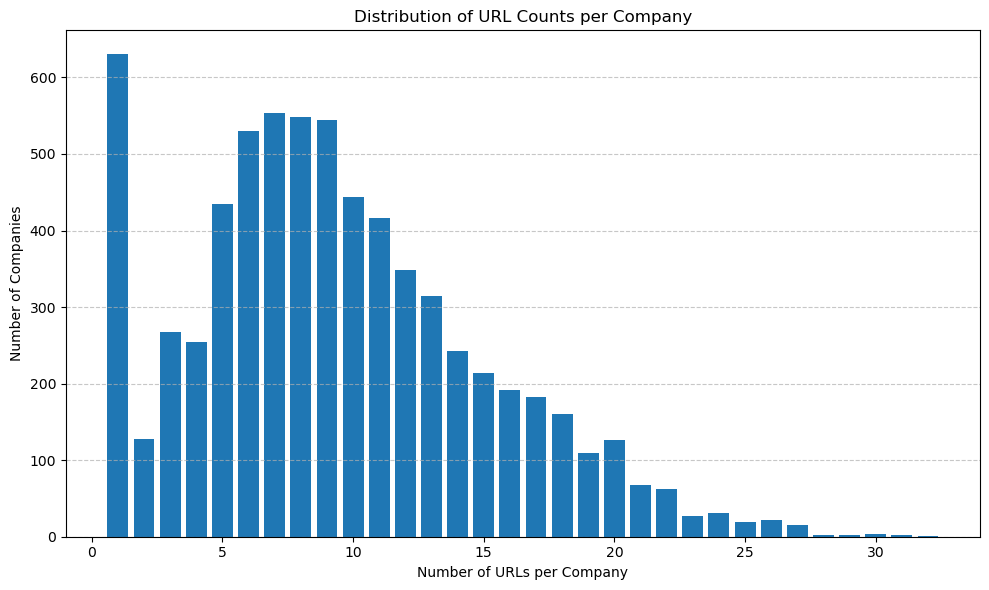

In [20]:
# Count how many companies have a given number of URLs
count_distribution = url_counts['url_count'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(count_distribution.index, count_distribution.values)
plt.xlabel("Number of URLs per Company")
plt.ylabel("Number of Companies")
plt.title("Distribution of URL Counts per Company")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Clean a bit

In [22]:
import re
import unicodedata
import spacy
import pandas as pd
from nltk.corpus import stopwords as sw
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm import tqdm

tqdm.pandas()          # Enable for pandas

# Load spaCy for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Build stopword set (NLTK + common boilerplate/URL remnants)
stop_words = set(sw.words("english"))
stop_words.update({"ltd", "inc", "www", "com", "http", "https", "org", "net", "edu", "gov", "co", "uk", "us", "ca", "jp", "fr", "de", "html", "php", "asp"})

# Compile your regexes once
URL_DOTTED = re.compile(r'^(?:https?://)?(?:www\.)?[A-Za-z0-9-]+(?:\.[A-Za-z0-9-]+)+(?:/.*)?$', re.IGNORECASE)
URL_GLUED  = re.compile(r'^www[a-z0-9\-]+$', re.IGNORECASE)
NON_ASCII  = re.compile(r'[^\x00-\x7F]')
HAS_DIGIT  = re.compile(r'\d')

# Boilerplate stop-tokens
BOILERPLATE = {
    'ltd','inc','www','com','http','https',
}

# Days of the week and months
TIME_WORDS = {
    "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
    "jan", "january", "feb", "february", "mar", "march", "apr", "april",
    "may", "jun", "june", "jul", "july", "aug", "august",
    "sep", "sept", "september", "oct", "october",
    "nov", "november", "dec", "december"
}

def clean_tokens(text):
    out = []
    for tok in text.split('|'):
        t = tok.strip().lower()
        if not t:
            continue

        # RL/domain?
        if URL_DOTTED.match(t) or URL_GLUED.match(t):
            continue

        # non-ASCII?
        if NON_ASCII.search(t):
            continue

        # any digit?
        if HAS_DIGIT.search(t):
            continue

        # Remove short, boilerplate, time-related tokens
        if t in BOILERPLATE or t in TIME_WORDS or len(t) < 2:
            continue

        if t.endswith("com"):
            continue

        out.append(t)

    return "|".join(out)

    # Lemmatize filtered tokens
    # doc = nlp(" ".join(out))  # Create a spaCy doc for lemmatization
    # lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 1]

sample_data = data.copy()  # or whatever your frame is
sample_data['cleaned'] = sample_data['text'].progress_apply(clean_tokens)
data = sample_data
sample_data

c:\Users\Dell Precision\anaconda3\envs\fpt01\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 64643/64643 [00:15<00:00, 4140.65it/s]


,hojin_id,company_name,url,weight,text,sents,hightechflag,us_flag,cleaned
0,703454,Wall Street Media Co.,https://wallstreetmediaco.net/investors/,0.027877,wallstreetmediaconet|wallstreetcom|millennials|generation|streetcom|marketing|app|innovation|bit...,nasdaq|following|raymond|otcqb|concentrated|assets|january|understanding|international|property|...,0.0,1,wallstreetmediaconet|millennials|generation|marketing|app|innovation|bitcoins|communications|fin...
1,703454,Wall Street Media Co.,https://wallstreetmediaco.net/a-i-powers-the-future-of-media/,0.123040,media|future|multimedia|technology|technologies|tech|innovators|journalists|innovation|innovatio...,reward|augment|accuracy|gold|assets|january|technique|capture|digital|amounts|small|trust|apples...,0.0,1,media|future|multimedia|technology|technologies|tech|innovators|journalists|innovation|innovatio...
2,703454,Wall Street Media Co.,https://wallstreetmediaco.net/green-retail-and-manufacture-is-the-onus-on-the-buyer-or-the-seller/,0.106928,green|environmentally|environment|marketing|journalism|survey|news|market|consumers|reporter|res...,march|materials|general|heat|margins|sellers|borqs|denise|august|households|producing|dna|passed...,0.0,1,green|environmentally|environment|marketing|journalism|survey|news|market|consumers|reporter|res...
3,703454,Wall Street Media Co.,https://wallstreetmediaco.net/pebble-life-science-research-development-innovation/,0.101823,innovation|innovations|innovators|innovative|health|news|evolving|infopebblelifesciencecom|lives...,harness|reported|hope|machine|january|preventive|capture|digital|clandestine|issued|trust|apples...,0.0,1,innovation|innovations|innovators|innovative|health|news|evolving|lives|life|healthier|future|de...
4,703454,Wall Street Media Co.,https://wallstreetmediaco.net/,0.096351,innovation|innovations|innovators|news|new|technology|social|digital|nov|technologies|health|mea...,mastering|march|manufacture|borqs|august|daniel|artificial|kirby|ehic|degree|july|technologies|e...,0.0,1,innovation|innovations|innovators|news|new|technology|social|digital|technologies|health|measure...
...,...,...,...,...,...,...,...,...,...
64638,705967,Plus Therapeutics,https://plustherapeutics.com/,0.238283,cancer|radiotherapeutics|cancers|carcinoma|radiotherapeutic|radionuclide|radiation|radioemboliza...,radiotherapeutic|colorectal|drug|patents|radiation|gbm|microspheres|hepatocellular|microsphere|d...,1.0,1,cancer|radiotherapeutics|cancers|carcinoma|radiotherapeutic|radionuclide|radiation|radioemboliza...
64639,706491,micromobility.com,https://micromobility.com/account/login?return_url=%2Faccount,0.154904,micromobilitycom|long|scooters|policy|password|terms|bikes|account|mobility|sustainability|inves...,cart|terms|mail|content|personal|scooters,0.0,1,long|scooters|policy|password|terms|bikes|account|mobility|sustainability|investors|privacy|stor...
64640,706491,micromobility.com,https://micromobility.com/pages/shared-mobility,0.329354,micromobilitycom|traffic|mapbox|transportation|cities|mopeds|mobility|openstreetmap|transit|map|...,vehicles|infrastructure|safer|mopeds|cleaner|continents|air|united|shipping|free|openstreetmap|l...,0.0,1,traffic|mapbox|transportation|cities|mopeds|mobility|openstreetmap|transit|map|vehicles|cart|com...
64641,706491,micromobility.com,https://ir.micromobility.com/,0.242320,micromobilitycom|events|investors|investor|opportunities|mcom|progress|continues|news|financials...,navigation|soon|nasdaq|mcom|constructive|december|atlas|advancements|amidst|company,0.0,1,events|investors|investor|opportunities|progress|continues|news|financials|advancements|nasdaq|q...


In [23]:
# # Load BERT NER model from Hugging Face (CoNLL-2003 fine-tuned)
# ner_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
# ner_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
# ner_pipeline = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="simple")

# def run_ner_on_cleaned(text):
#     """Apply NER and keep only entities of types PER, ORG, LOC"""
#     if not text.strip():
#         return ""
#     ner_results = ner_pipeline(text)
#     filtered = [ent['word'] for ent in ner_results if ent['entity_group'] in {"PER", "ORG", "LOC"}]
#     return "|".join(filtered)


In [24]:
# data

In [25]:
# # Sample application to your DataFrame
# sample_data = data.copy()
# sample_data['cleaned'] = sample_data['text'].progress_apply(clean_tokens)
# sample_data['ner_entities'] = sample_data['cleaned'].progress_apply(run_ner_on_cleaned)

# # Show result
# print(sample_data[['url', 'text', 'cleaned', 'ner_entities']].head())

In [26]:
# sampled_data = data.sample(frac=0.3, random_state=42).reset_index(drop=True)

# # Sample 10 rows only for quick overfit testing
# # sampled_data = data.sample(n=184, random_state=42).reset_index(drop=True)
# # sampled_data = data.head(10000).reset_index(drop=True)

# data_store = data 
# data = sampled_data

# # print("Original size:", data.shape)
# # print("Sampled 10% size:", sampled_data.shape)

# data

In [27]:
data_store = data 
data_used = data_store[['hojin_id', 'company_name', 'url', 'cleaned', 'hightechflag']].drop_duplicates()
data_used 


,hojin_id,company_name,url,cleaned,hightechflag
0,703454,Wall Street Media Co.,https://wallstreetmediaco.net/investors/,wallstreetmediaconet|millennials|generation|marketing|app|innovation|bitcoins|communications|fin...,0.0
1,703454,Wall Street Media Co.,https://wallstreetmediaco.net/a-i-powers-the-future-of-media/,media|future|multimedia|technology|technologies|tech|innovators|journalists|innovation|innovatio...,0.0
2,703454,Wall Street Media Co.,https://wallstreetmediaco.net/green-retail-and-manufacture-is-the-onus-on-the-buyer-or-the-seller/,green|environmentally|environment|marketing|journalism|survey|news|market|consumers|reporter|res...,0.0
3,703454,Wall Street Media Co.,https://wallstreetmediaco.net/pebble-life-science-research-development-innovation/,innovation|innovations|innovators|innovative|health|news|evolving|lives|life|healthier|future|de...,0.0
4,703454,Wall Street Media Co.,https://wallstreetmediaco.net/,innovation|innovations|innovators|news|new|technology|social|digital|technologies|health|measure...,0.0
...,...,...,...,...,...
64638,705967,Plus Therapeutics,https://plustherapeutics.com/,cancer|radiotherapeutics|cancers|carcinoma|radiotherapeutic|radionuclide|radiation|radioemboliza...,1.0
64639,706491,micromobility.com,https://micromobility.com/account/login?return_url=%2Faccount,long|scooters|policy|password|terms|bikes|account|mobility|sustainability|investors|privacy|stor...,0.0
64640,706491,micromobility.com,https://micromobility.com/pages/shared-mobility,traffic|mapbox|transportation|cities|mopeds|mobility|openstreetmap|transit|map|vehicles|cart|com...,0.0
64641,706491,micromobility.com,https://ir.micromobility.com/,events|investors|investor|opportunities|progress|continues|news|financials|advancements|nasdaq|q...,0.0


In [28]:
data_used = data_used.rename(columns={'cleaned': 'cleaned_content', 'url': 'urls'})
data_used


,hojin_id,company_name,urls,cleaned_content,hightechflag
0,703454,Wall Street Media Co.,https://wallstreetmediaco.net/investors/,wallstreetmediaconet|millennials|generation|marketing|app|innovation|bitcoins|communications|fin...,0.0
1,703454,Wall Street Media Co.,https://wallstreetmediaco.net/a-i-powers-the-future-of-media/,media|future|multimedia|technology|technologies|tech|innovators|journalists|innovation|innovatio...,0.0
2,703454,Wall Street Media Co.,https://wallstreetmediaco.net/green-retail-and-manufacture-is-the-onus-on-the-buyer-or-the-seller/,green|environmentally|environment|marketing|journalism|survey|news|market|consumers|reporter|res...,0.0
3,703454,Wall Street Media Co.,https://wallstreetmediaco.net/pebble-life-science-research-development-innovation/,innovation|innovations|innovators|innovative|health|news|evolving|lives|life|healthier|future|de...,0.0
4,703454,Wall Street Media Co.,https://wallstreetmediaco.net/,innovation|innovations|innovators|news|new|technology|social|digital|technologies|health|measure...,0.0
...,...,...,...,...,...
64638,705967,Plus Therapeutics,https://plustherapeutics.com/,cancer|radiotherapeutics|cancers|carcinoma|radiotherapeutic|radionuclide|radiation|radioemboliza...,1.0
64639,706491,micromobility.com,https://micromobility.com/account/login?return_url=%2Faccount,long|scooters|policy|password|terms|bikes|account|mobility|sustainability|investors|privacy|stor...,0.0
64640,706491,micromobility.com,https://micromobility.com/pages/shared-mobility,traffic|mapbox|transportation|cities|mopeds|mobility|openstreetmap|transit|map|vehicles|cart|com...,0.0
64641,706491,micromobility.com,https://ir.micromobility.com/,events|investors|investor|opportunities|progress|continues|news|financials|advancements|nasdaq|q...,0.0


In [29]:
data_used.nunique()

hojin_id            6893
company_name        6893
urls               55048
cleaned_content    54261
hightechflag           2
dtype: int64

In [30]:
data = data_used

New block of code to load only the vec of words in the training data 

In [31]:
all_words = [word for content_string in data['cleaned_content'] for word in content_string.split('|')]
unique_words = set(all_words)
print(len(unique_words))

208064


Create and save a word-vector dictionary only for words in the training data 

In [32]:
# filtered_word_vecs = {
#     word: en_dictionary[word]
#     for word in unique_words
#     if word in en_dictionary
# }

# print(f"Filtered FastText vocabulary size: {len(filtered_word_vecs)}")

# # Save to fastText .vec format (word followed by vector values)
# output_vec_path = r"C:\Users\Daryn Bang\Desktop\Internship\reduced_fasttext.vec"

# with open(output_vec_path, "w", encoding="utf-8") as f:
#     dim = len(next(iter(filtered_word_vecs.values())))
#     f.write(f"{len(filtered_word_vecs)} {dim}\n")
#     for word, vec in filtered_word_vecs.items():
#         vec_str = " ".join([f"{x:.6f}" for x in vec])
#         f.write(f"{word} {vec_str}\n")

# print(f"Saved reduced FastText vectors to: {output_vec_path}")


In [33]:
# vec_path = r'C:\PDZ\Intern\Shared_2025\Phase 2\reduced_fasttext.vec'
vec_path = r'C:\PDZ\Intern\Shared_2025\Phase 2\fasttext_web_patent.vec'

In [34]:
en_dictionary_reduced = FastVector(vector_file=vec_path)

words = list(en_dictionary_reduced.word2id.keys())
vectors = np.array([en_dictionary_reduced[word] for word in words])

wv_dict= dict(zip(words, vectors))


reading word vectors from C:\PDZ\Intern\Shared_2025\Phase 2\fasttext_web_patent.vec


In [35]:
en_dictionary = en_dictionary_reduced

In [36]:
print(words[:200])
print(len(words))


['shri', 'charité', 'psychotropic', 'ethyl', 'iiil', 'skya', 'arching', 'twn', 'magento', '16c', 'buxton', 'chainsaw', 'experiance', 'semipermeable', '10507', '8696', '9677', 'santiago', 'outrank', 'rosalie', 'nudity', 'completi', 'bubblegum', 'aldrich', 'anaylsis', 'solubilize', 'neurologic', 'rejuvenate', 'multilobed', 'ahern', 'wharves', 'striker', '0513', 'hematopoietic', 'interphase', 'fated', 'biro', 'fixably', 'nonperishable', 'syscalls', 'transposes', 'markee', '708', 'shortly', 'ridgeway', 'tam', 'rent', 'microcrustaceans', 'toefl', 'afterwards', 'dactylifera', 'agriculture', 'scatterer', 'neuropathy', 'melena', 'worthy', 'tradición', '8734', 'goldens', 'stirs', '8834', 'tapping', 'mongoose', 'intranasally', 'hys', 'comma', 'cartography', 'hypothalamic', '4894', 'goodall', '9061', 'pendo', 'neurosphere', 'multiterminal', 'ali', 'granularities', 'exomes', 'reuses', 'helmsley', '00005', 'minnow', 'ihas', 'usp', 'spem', '7469', 'staggered', 'cinelli', 'watters', 'burst', 'roadwor

In [37]:
vectors[0].shape

(300,)

# Process the data

In [38]:
no_values = []

for i in tqdm(data.cleaned_content):
    try:
        i = i.split('|')
        i = [j for j in i if j in wv_dict]
        if len(i) < 1:
            no_values.append(1)
        else:
            no_values.append(0)
    except:
        no_values.append(1)

data['no_values'] = no_values
data = data[data.no_values == 0]
data = data[['hojin_id', 'company_name', 'urls', 'cleaned_content', 'hightechflag']]


100%|██████████| 64643/64643 [00:02<00:00, 31181.16it/s]


In [39]:
data

,hojin_id,company_name,urls,cleaned_content,hightechflag
0,703454,Wall Street Media Co.,https://wallstreetmediaco.net/investors/,wallstreetmediaconet|millennials|generation|marketing|app|innovation|bitcoins|communications|fin...,0.0
1,703454,Wall Street Media Co.,https://wallstreetmediaco.net/a-i-powers-the-future-of-media/,media|future|multimedia|technology|technologies|tech|innovators|journalists|innovation|innovatio...,0.0
2,703454,Wall Street Media Co.,https://wallstreetmediaco.net/green-retail-and-manufacture-is-the-onus-on-the-buyer-or-the-seller/,green|environmentally|environment|marketing|journalism|survey|news|market|consumers|reporter|res...,0.0
3,703454,Wall Street Media Co.,https://wallstreetmediaco.net/pebble-life-science-research-development-innovation/,innovation|innovations|innovators|innovative|health|news|evolving|lives|life|healthier|future|de...,0.0
4,703454,Wall Street Media Co.,https://wallstreetmediaco.net/,innovation|innovations|innovators|news|new|technology|social|digital|technologies|health|measure...,0.0
...,...,...,...,...,...
64638,705967,Plus Therapeutics,https://plustherapeutics.com/,cancer|radiotherapeutics|cancers|carcinoma|radiotherapeutic|radionuclide|radiation|radioemboliza...,1.0
64639,706491,micromobility.com,https://micromobility.com/account/login?return_url=%2Faccount,long|scooters|policy|password|terms|bikes|account|mobility|sustainability|investors|privacy|stor...,0.0
64640,706491,micromobility.com,https://micromobility.com/pages/shared-mobility,traffic|mapbox|transportation|cities|mopeds|mobility|openstreetmap|transit|map|vehicles|cart|com...,0.0
64641,706491,micromobility.com,https://ir.micromobility.com/,events|investors|investor|opportunities|progress|continues|news|financials|advancements|nasdaq|q...,0.0


In [40]:
hojin_ids = list(set(data.hojin_id))

sample_data = pd.DataFrame({})
max_page = 32

for hojin_id in tqdm(hojin_ids):
    temp = data[data.hojin_id == hojin_id]
    if temp.shape[0] <= max_page:
        sample_data = pd.concat([sample_data, temp], ignore_index=True)
    else:
        temp = temp.sample(n=max_page)
        sample_data = pd.concat([sample_data, temp], ignore_index=True)
        # sample_data = pd.concat([sample_data, temp.iloc[:max_page, :]], ignore_index=True)

num_words = [len(i.split('|')) for i in sample_data.cleaned_content]
sample_data['num_words'] = num_words
sample_data = sample_data[sample_data.num_words > 5]

hojin_ids = list(set(sample_data.hojin_id))
hojin_ids = [int(i) for i in hojin_ids]

tokenizer = Tokenizer(words, data = sample_data, max_len=864)

web_vectors = [tokenizer.encode_webportfolio(company_id=idx, max_page=max_page) for idx in tqdm(hojin_ids)]

seq_ids = torch.tensor([i[1] for i in web_vectors])
num_pages = torch.tensor([i[0] for i in web_vectors])
seq_lengths = tokenizer.max_len - torch.sum(seq_ids == 0, axis=-1)

labels = torch.tensor([tokenizer.get_label(i) for i in hojin_ids])
hojin_ids = torch.tensor(hojin_ids)


100%|██████████| 6764/6764 [00:07<00:00, 900.69it/s] 


# Prepare training data

In [41]:
# Define your dataset
dataset = TensorDataset(seq_ids, num_pages, seq_lengths, labels, hojin_ids)

# Set batch size
batch_size = 10

# Set the sizes (e.g., 80% train, 10% val, 10% test)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # ensure full coverage

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print number of samples in each set
print(f"Total samples      : {total_size}")
print(f"Training samples   : {len(train_dataset)}")
print(f"Validation samples : {len(val_dataset)}")
print(f"Test samples       : {len(test_dataset)}")

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,        # Adjust depending on CPU cores
    pin_memory=True       # Required for faster GPU transfers
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Total samples      : 6764
Training samples   : 5411
Validation samples : 676
Test samples       : 677


In [42]:
def evaluate(model, data_loader):
    """Evaluate model and return metrics"""
    model.eval()
    gold_labels = []
    pred_probs = []
    pred_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", ncols=100):
            seq_ids, num_pages, seq_lengths, label_list, hojin = batch
            
            # print("Evaluation: unique labels:", torch.unique(label_list))
            
            outputs, *_ = model(seq_ids.to(device), num_pages.to(device), seq_lengths.to(device))
            # probs = outputs.squeeze().cpu().numpy()
            probs = outputs.view(-1).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            # Make sure probs is iterable
            if np.isscalar(probs):
                probs = [probs]
                preds = [preds]

            gold_labels.extend(label_list.cpu().numpy())
            pred_probs.extend(probs)
            pred_labels.extend(preds)

    # Compute metrics
    acc = accuracy_score(gold_labels, pred_labels)
    prec = precision_score(gold_labels, pred_labels, zero_division=0)
    rec = recall_score(gold_labels, pred_labels, zero_division=0)
    f1 = f1_score(gold_labels, pred_labels, zero_division=0)
    roc = roc_auc_score(gold_labels, pred_probs)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc
    }

    return metrics

def train(model, train_dataloader, val_dataloader, optimizer, loss_function, num_epochs=10):
    """Training loop"""
    start_time = time.time()
    # Training loop...
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_metrics": [],
        "val_metrics": []
    }

    best_model = None
    best_val_acc = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*30)
        print("Epoch time:", time.time() - start_time, "seconds")
        
        model.train()
        total_loss = 0
        count = 0

        for batch in tqdm(train_dataloader, desc="Training", ncols=100):
            seq_ids, num_pages, seq_lengths, label_list, hojin = batch

            optimizer.zero_grad()
            
            # print(seq_ids.shape)
            # print(num_pages.shape)
            # print(seq_lengths.shape)            
            
            # ---- old ----
            preds, *_ = model(seq_ids.to(device), num_pages.to(device), seq_lengths.to(device))
            
            # print(preds.shape)
            # print(label_list.shape)
            
            # print("Raw labels:", label_list)
            # print("Unique labels:", torch.unique(label_list))
            # print("Model output (probs) min/max:", preds.min().item(), preds.max().item())
            
            # Before computing loss
            assert label_list.max() <= 1 and label_list.min() >= 0, \
                f"[ERROR] label_list must be in [0,1], but got min={label_list.min()} max={label_list.max()}"
            
            # loss = loss_function(preds.squeeze(), label_list.to(device).float())
            loss = loss_function(preds.view(-1), label_list.to(device).float().view(-1))
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * seq_ids.size(0)
            count += seq_ids.size(0)

        avg_train_loss  = total_loss / count
        history["train_loss"].append(avg_train_loss )

        # Evaluate on training and validation set
        train_metrics = evaluate(model, train_dataloader)
        
        # Evaluate on validation set & compute val loss
        model.eval()
        val_loss_total = 0
        val_count = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Computing Val Loss", ncols=100):
                seq_ids, num_pages, seq_lengths, label_list, hojin = batch
                preds, *_ = model(seq_ids.to(device), num_pages.to(device), seq_lengths.to(device))
                
                # loss = loss_function(preds.squeeze(), label_list.to(device).float())
                loss = loss_function(preds.view(-1), label_list.to(device).float())
                
                val_loss_total += loss.item() * seq_ids.size(0)
                val_count += seq_ids.size(0)

        avg_val_loss = val_loss_total / val_count
        history["val_loss"].append(avg_val_loss)
        
        val_metrics = evaluate(model, val_dataloader)

        history["train_metrics"].append(train_metrics)
        history["val_metrics"].append(val_metrics)

        print(f"\nTrain Loss: {avg_train_loss:.4f}")
        print(f"Val Loss  : {avg_val_loss:.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Val Metrics  : {val_metrics}")

        # Save best model
        if val_metrics["accuracy"] > best_val_acc:
            best_val_acc = val_metrics["accuracy"]
            best_model = model.state_dict()

    print("\nTraining finished!")
    return best_model, history


In [43]:
vectors = np.array(list(wv_dict.values()))
words = list(wv_dict.keys())
vectors_all = np.vstack([np.zeros(300), vectors])


# Model Init

In [44]:
def count_parameters(model):
    """
    Print the number of trainable and total parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    return total_params, trainable_params


## Training

In [45]:
# Initialize model
model = DualAttnModel(vocab_size=len(words)+1, embed_dim=300, hidden_dim=300,
                      label_dim=1, scale=10, page_scale=10)
model.load_vector(pretrained_vectors=vectors_all, trainable=False)
model = model.to(device)

# Set loss and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.02, weight_decay=0.0000, lr_decay=0.01)


Dual Att Model: Embeddings loaded


In [ ]:
count_parameters(model)

Total Parameters: 37,421,100
Trainable Parameters: 182,700


(37421100, 182700)

In [47]:
# Train
best_model_state, training_history = train(model, train_dataloader, val_dataloader, optimizer, loss_function, num_epochs=10)



Epoch 1/10
------------------------------
Epoch time: 0.0 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:04<00:00, 16.87it/s]



Train Loss: 0.6036
Val Loss  : 0.5234
Train Metrics: {'accuracy': 0.7405285529476991, 'precision': 0.7473587505741847, 'recall': 0.6557839580814188, 'f1_score': 0.6985830828681838, 'roc_auc': 0.8048642722231623}
Val Metrics  : {'accuracy': 0.7396449704142012, 'precision': 0.7217741935483871, 'recall': 0.6258741258741258, 'f1_score': 0.6704119850187266, 'roc_auc': 0.8168101129639591}

Epoch 2/10
------------------------------
Epoch time: 53.29303169250488 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:07<00:00,  9.17it/s]



Train Loss: 0.5636
Val Loss  : 0.5212
Train Metrics: {'accuracy': 0.7418222140085012, 'precision': 0.7312286689419796, 'recall': 0.6908504635227731, 'f1_score': 0.7104663212435233, 'roc_auc': 0.8074837708564613}
Val Metrics  : {'accuracy': 0.7485207100591716, 'precision': 0.7101449275362319, 'recall': 0.6853146853146853, 'f1_score': 0.697508896797153, 'roc_auc': 0.8197238658777121}

Epoch 3/10
------------------------------
Epoch time: 114.67720890045166 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:05<00:00, 12.70it/s]



Train Loss: 0.5719
Val Loss  : 0.5204
Train Metrics: {'accuracy': 0.7408981703936426, 'precision': 0.728311468472281, 'recall': 0.6936719064893189, 'f1_score': 0.7105697770437654, 'roc_auc': 0.8083830972042816}
Val Metrics  : {'accuracy': 0.75, 'precision': 0.7096774193548387, 'recall': 0.6923076923076923, 'f1_score': 0.7008849557522124, 'roc_auc': 0.8205441993903533}

Epoch 4/10
------------------------------
Epoch time: 178.5503695011139 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:05<00:00, 11.68it/s]



Train Loss: 0.5699
Val Loss  : 0.5188
Train Metrics: {'accuracy': 0.7429310663463315, 'precision': 0.7365451388888888, 'recall': 0.6839983877468763, 'f1_score': 0.7092998955067921, 'roc_auc': 0.8086519665498746}
Val Metrics  : {'accuracy': 0.7529585798816568, 'precision': 0.7211895910780669, 'recall': 0.6783216783216783, 'f1_score': 0.6990990990990991, 'roc_auc': 0.8207862650170343}

Epoch 5/10
------------------------------
Epoch time: 237.2051384449005 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:05<00:00, 12.21it/s]



Train Loss: 0.5635
Val Loss  : 0.5185
Train Metrics: {'accuracy': 0.7429310663463315, 'precision': 0.7345094664371773, 'recall': 0.6880290205562273, 'f1_score': 0.7105098855359001, 'roc_auc': 0.8090054379151862}
Val Metrics  : {'accuracy': 0.7485207100591716, 'precision': 0.7132352941176471, 'recall': 0.6783216783216783, 'f1_score': 0.6953405017921147, 'roc_auc': 0.8211538461538461}

Epoch 6/10
------------------------------
Epoch time: 294.3731517791748 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:05<00:00, 11.42it/s]



Train Loss: 0.5618
Val Loss  : 0.5181
Train Metrics: {'accuracy': 0.7431158750693033, 'precision': 0.7350280051701853, 'recall': 0.6876259572752922, 'f1_score': 0.7105372761349438, 'roc_auc': 0.8092410854920604}
Val Metrics  : {'accuracy': 0.7485207100591716, 'precision': 0.7132352941176471, 'recall': 0.6783216783216783, 'f1_score': 0.6953405017921147, 'roc_auc': 0.8213914290837369}

Epoch 7/10
------------------------------
Epoch time: 354.98550295829773 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:05<00:00, 11.45it/s]



Train Loss: 0.5635
Val Loss  : 0.5179
Train Metrics: {'accuracy': 0.7423766401774163, 'precision': 0.7335625268586162, 'recall': 0.6880290205562273, 'f1_score': 0.7100665557404326, 'roc_auc': 0.8095011507250325}
Val Metrics  : {'accuracy': 0.7485207100591716, 'precision': 0.7101449275362319, 'recall': 0.6853146853146853, 'f1_score': 0.697508896797153, 'roc_auc': 0.8217141832526448}

Epoch 8/10
------------------------------
Epoch time: 414.85990357398987 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:05<00:00, 11.64it/s]



Train Loss: 0.5707
Val Loss  : 0.5177
Train Metrics: {'accuracy': 0.7423766401774163, 'precision': 0.7335625268586162, 'recall': 0.6880290205562273, 'f1_score': 0.7100665557404326, 'roc_auc': 0.8096685664290932}
Val Metrics  : {'accuracy': 0.7514792899408284, 'precision': 0.7122302158273381, 'recall': 0.6923076923076923, 'f1_score': 0.7021276595744681, 'roc_auc': 0.8219607315761162}

Epoch 9/10
------------------------------
Epoch time: 474.68379068374634 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:04<00:00, 15.17it/s]



Train Loss: 0.5637
Val Loss  : 0.5175
Train Metrics: {'accuracy': 0.7427462576233598, 'precision': 0.7343951786482996, 'recall': 0.6876259572752922, 'f1_score': 0.7102414654454621, 'roc_auc': 0.8097539938343699}
Val Metrics  : {'accuracy': 0.7514792899408284, 'precision': 0.7137681159420289, 'recall': 0.6888111888111889, 'f1_score': 0.701067615658363, 'roc_auc': 0.8220772816926663}

Epoch 10/10
------------------------------
Epoch time: 556.8976118564606 seconds


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:03<00:00, 17.65it/s]


Train Loss: 0.5618
Val Loss  : 0.5173
Train Metrics: {'accuracy': 0.7427462576233598, 'precision': 0.7343951786482996, 'recall': 0.6876259572752922, 'f1_score': 0.7102414654454621, 'roc_auc': 0.8098438920780869}
Val Metrics  : {'accuracy': 0.7514792899408284, 'precision': 0.7137681159420289, 'recall': 0.6888111888111889, 'f1_score': 0.701067615658363, 'roc_auc': 0.8222117625963778}

Training finished!


In [48]:
# Save just the model weights (recommended)
torch.save(best_model_state, "dual_attn_model_state.pth")

## Testing

In [49]:
# Correct vocab_size and pretrained vectors
model_load = DualAttnModel(vocab_size=vectors_all.shape[0], embed_dim=300, hidden_dim=300,
                           label_dim=1, scale=10, page_scale=10)

model_load.load_vector(pretrained_vectors=vectors_all, trainable=False)  # Required for same shape
model_load = model_load.to(device)

model_load.load_state_dict(torch.load("dual_attn_model_state.pth"))
model_load.eval()

# Then run evaluation
test_metrics_load = evaluate(model_load, test_dataloader)
print("\nTest Metrics:", test_metrics_load)


Dual Att Model: Embeddings loaded


Evaluating: 100%|███████████████████████████████████████████████████| 68/68 [00:00<00:00, 73.95it/s]


Test Metrics: {'accuracy': 0.7533234859675036, 'precision': 0.7448275862068966, 'recall': 0.6990291262135923, 'f1_score': 0.7212020033388982, 'roc_auc': 0.8015908611228366}


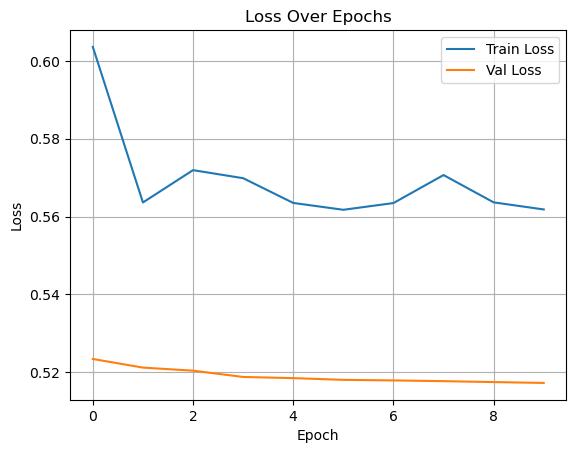

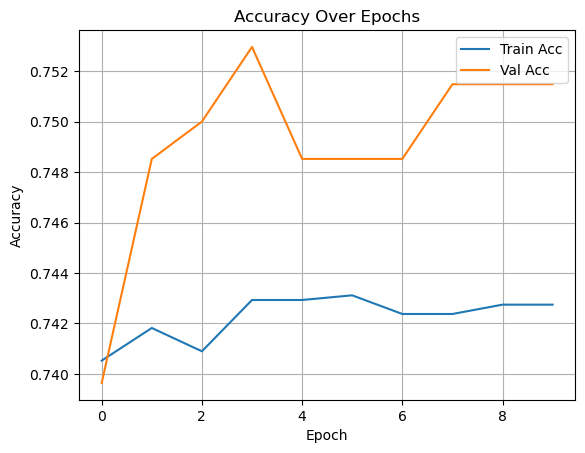

In [50]:
# Plot Loss (Train vs Val)
plt.plot(training_history["train_loss"], label="Train Loss")
plt.plot(training_history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
train_acc = [m["accuracy"] for m in training_history["train_metrics"]]
val_acc = [m["accuracy"] for m in training_history["val_metrics"]]

plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Test MHA Dual Attention Model

In [51]:
# device 

In [52]:
# # Initialize model
# model_mha = DualAttnModel(vocab_size=len(words)+1, embed_dim=300, hidden_dim=300,
#                       label_dim=1, scale=10, page_scale=10, attn_word=True)
# model_mha.load_vector(pretrained_vectors=vectors_all, trainable=False)
# model_mha = model_mha.to(device)

# # Set loss and optimizer
# loss_function_mha = nn.BCELoss()
# # loss_function_mha = nn.BCEWithLogitsLoss() 
# optimizer_mha = torch.optim.Adagrad(model_mha.parameters(), lr=0.02, weight_decay=0.0000, lr_decay=0.01)


In [53]:
# count_parameters(model_mha)

In [54]:
# # Train
# best_model_state_mha, training_history_mha = train(model_mha, train_dataloader, val_dataloader, optimizer_mha, loss_function_mha, num_epochs=1)


In [55]:
# # Save just the model weights (recommended)
# torch.save(best_model_state_mha, "dual_attn_model_state_mha.pth")

In [56]:
# # Correct vocab_size and pretrained vectors
# model_mha_load = DualAttnModel(vocab_size=vectors_all.shape[0], embed_dim=300, hidden_dim=300,
#                            label_dim=1, scale=10, page_scale=10, use_mha=True)

# model_mha_load.load_vector(pretrained_vectors=vectors_all, trainable=False)  # Required for same shape
# model_mha_load = model_mha_load.to(device)

# model_mha_load.load_state_dict(torch.load("dual_attn_model_state_mha.pth"))
# model_mha_load.eval()

# # Then run evaluation
# test_metrics_load_mha = evaluate(model_mha_load, test_dataloader)
# print("\nTest Metrics:", test_metrics_load_mha)


In [57]:
# # Plot Loss (Train vs Val)
# plt.plot(training_history_mha["train_loss"], label="Train Loss")
# plt.plot(training_history_mha["val_loss"], label="Val Loss")
# plt.title("Loss Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot accuracy
# train_acc = [m["accuracy"] for m in training_history_mha["train_metrics"]]
# val_acc = [m["accuracy"] for m in training_history_mha["val_metrics"]]

# plt.plot(train_acc, label="Train Acc")
# plt.plot(val_acc, label="Val Acc")
# plt.title("Accuracy Over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)
# plt.show()


In [58]:
# model = model_mha_load

# Collect the results

In [59]:
words = list(en_dictionary.word2id.keys())
vectors = np.array([en_dictionary[word] for word in words])
wv_dict = dict(zip(words, vectors))

hojin_ids = list(set(sample_data.hojin_id))
hojin_ids = [int(i) for i in hojin_ids]

tokenizer = Tokenizer(words, max_len=864, data = sample_data)

# return # pages and web vectors
web_vectors = [tokenizer.encode_webportfolio(company_id=idx, max_page=max_page) for idx in tqdm(hojin_ids)]


100%|██████████| 6764/6764 [00:09<00:00, 750.01it/s] 


In [60]:
# Prepare input tensors
seq_ids = torch.tensor([i[1] for i in web_vectors])
num_pages = torch.tensor([i[0] for i in web_vectors])
seq_lengths = tokenizer.max_len - torch.sum(seq_ids == 0, axis=-1)
labels = torch.tensor([tokenizer.get_label(i) for i in hojin_ids])
hojin_ids = torch.tensor(hojin_ids)

In [61]:
def colorize(words, color_array):
    """Generate a colored HTML string for visualization, where word background intensity reflects its importance."""
    cmap=matplotlib.cm.Blues
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        # Maps each attention score (or weight) to a color using matplotlib.cm.Blues colormap.
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        # print(color)
        
        # Wraps each word with HTML <span> using background color:
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

def select_keywords(attn_w, words, n=10):
    """Select the top-N most important words based on attention weights."""
    # Filter out zero-attention words.
    combo = [(i, j) for i, j in zip(attn_w, words) if i != 0]
    
    # Transform inputs:
    attn_w = np.array([i[0] for i in combo])
    words = [i[1] for i in combo]
    
    # Compute "attention distance" from the most attended word:
    attn_diff = attn_w.max() - attn_w
    
    # Select words whose attention is in the top-n percentile:
    attn_thres = np.percentile(attn_diff, n)
    selected_keywords = [i for i, j in zip(words, attn_diff) if j <= attn_thres]
    selected_keywords_show = [0.6 if j <= attn_thres else 0 for i, j in zip(words, attn_diff)]
    return selected_keywords, selected_keywords_show


In [62]:
# class DualAttModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, label_dim=1, scale=10, page_scale=10, attn_type='dot'):
#         pass 
    
#     def forward(self, seq_ids, num_pages, seq_lengths=None):
#         ...
#         return probs, senti_scores, attn, page_attn, final_vec, page_scores, webpage_vec
    
#     def load_vector(self, pretrained_vectors, trainable=False):
#         pass


# Export the CSV Results and the Company Embeddings

In [ ]:
url_col = []
text_col = []
sents_selected = []
weight_col = []
hojin_id_col = []
hightechflag_col = []

final_vecs = []
web_vecs = []
page_attns = []
urls = []

company_embeddings = []

model.eval()

# Run the model for each company (hojin_id)
for t in tqdm(range(len(hojin_ids)), desc="Processing companies", ncols=100):
    # Running the trained DualAttnModel on each company’s document (a set of webpages) to get:
    # - attn: word-level attention (1 vector per page),
    # - page_attn: attention over pages (page importance),
    # - final_vec: representation of the entire company website,
    # - page_score: raw attention logits for pages.
    probs, senti_scores, attn, page_attn, final_vec, page_score, web_vec = model(seq_ids[t:(t+1)].to(device), num_pages[t:(t+1)].to(device), seq_lengths[t:(t+1)].to(device))

    id_to_token = tokenizer.id_to_token
    id_to_token[0] = '#'

    # Convert token IDs back to words
    # => Transform each page’s word IDs back into real words → forms the page's content as a sentence.
    sents = []
    for i in range(num_pages[t:(t+1)].tolist()[0]):
        sents.append(' '.join([id_to_token[w] for w in seq_ids[t:(t+1)][0][i].tolist()]))

    # For each page with non-zero attention, collect:
    # - URL of the page
    # - Company ID
    # - Original content
    # - Page attention weight
    # - Raw attention score
    final_vecs.append(final_vec.detach().cpu().numpy())

    # Store the company embedding along with its ID
    company_embeddings.append({
        "hojin_id": int(hojin_ids[t]),
        "embedding": final_vec.detach().cpu().numpy().squeeze()  # shape: (D,)
    })

    n_pages = num_pages[t:(t+1)].item()  # safely convert to Python int
    company_data = sample_data[sample_data.hojin_id == int(hojin_ids[t].tolist())]

    # print(f"\n[DEBUG] t={t}")
    # print("Num URLs       :", len(company_data.urls))
    # print("Num hojin_id   :", len(company_data.hojin_id))
    # print("Num flags      :", len(company_data.hightechflag))
    # print("Num texts      :", len(company_data.cleaned_content))
    # print("Num weights    :", len(page_attn.view(-1)[:num_pages[t:(t+1)].tolist()[0]]))
    # print("Num page_scores:", len(page_score.view(-1)[page_score.view(-1) > -9999]))

    # df = pd.DataFrame({'url':           list(sample_data[sample_data.hojin_id == int(hojin_ids[t].tolist())].urls),
    #                     'hojin_id':     list(sample_data[sample_data.hojin_id == int(hojin_ids[t].tolist())].hojin_id),
    #                     'hightechflag': list(sample_data[sample_data.hojin_id == int(hojin_ids[t].tolist())].hightechflag),
    #                     'text':         list(sample_data[sample_data.hojin_id == int(hojin_ids[t].tolist())].cleaned_content),
    #                     'weight':       page_attn.view(-1)[:num_pages[t:(t+1)].tolist()[0]].tolist(),
    #                     'page_score':   page_score.view(-1)[page_score.view(-1) > -9999].tolist(),
    #                     #'web_vecs':    list(web_vec[0])[:num_pages[t:(t+1)].tolist()[0]]
    #                 })

    df = pd.DataFrame({
        'url':           list(company_data.urls),
        'hojin_id':      list(company_data.hojin_id),
        'hightechflag':  list(company_data.hightechflag),
        'text':          list(company_data.cleaned_content),
        'weight':        page_attn.view(-1)[:n_pages].tolist(),
        'page_score':    page_score.view(-1)[:n_pages].tolist(),
        # 'web_vecs':    list(web_vec[0])[:n_pages]
    })

    # To get all the websites back together with those with zero weights of attention, we could remove this line of code
    df = df[df.weight > 0].reset_index()

    hojin_id_col.extend(df.hojin_id)
    hightechflag_col.extend(df.hightechflag)
    url_col.extend(df.url)
    text_col.extend(df.text)
    weight_col.extend(df.weight)

    # For each page, select keywords based on attention scores
    # For each important page:
    # - Retrieve its words and word-level attention scores,
    # - Select top-N attended words (via percentile threshold),
    # - Save them as the keywords that model considered important.
    for i in list(df['index']):
        sent = sents[i]
        attn1 = attn.squeeze()[i]

        words = sent.split()
        color_array = np.array(attn1.view(-1).tolist())

        selected_keywords, selected_keywords_show = select_keywords(color_array, words, n=20)
        html = colorize(words, selected_keywords_show)

        sents_selected.append([j for j, k in zip(words, selected_keywords_show) if k != 0])

# A list of distinct important words (selected via word-level attention scores).
sents_selected = ['|'.join(i) for i in sents_selected]
sents_selected = ['|'.join(list(set(i.split('|')))) for i in sents_selected]

# Final output contains:
# - Which pages (URLs) are most relevant (weight),
# - What words/sentences are important (sents),
# - Full raw text (text),
# - Associated company info (hojin_id, hightechflag).
selected_df = pd.DataFrame({
    'hojin_id': hojin_id_col,
    'url': url_col,
    'weight': weight_col,
    'text':text_col,            # full cleaned text content of a webpage
    'sents': sents_selected,    # important words/sentences from the webpage
    'hightechflag': hightechflag_col,
})

with open("company_embeddings.pkl", "wb") as f:
    pickle.dump(company_embeddings, f)


In [ ]:
selected_df

In [ ]:
selected_df.nunique()

In [ ]:
selected_df.to_csv("save_dual_attn_output.csv", index=False)

In [ ]:
# selected_df_path = r'C:\PDZ\Intern\Shared_2025\Phase 2\Multi_label\DualAttenMultilabel_Result\results_300_300_13labels\save_dual_attn_multilabel_output.csv'
# selected_df = pd.read_csv(selected_df_path)
# selected_df

,hojin_id,url,weight,text,sents,domain_label
0,700000,https://warriormetcoal.com/product/,0.727443,coal|cornerstone|mining|railway|mines|metallurgical|bridges|steel|structures|tomorrow|constructi...,scale|shipping|vehicles|inventory|industry|delivery|monumental|exporter|infrastructure|component...,4
1,700000,https://warriormetcoal.com/operations/,0.272557,mining|mines|coal|metallurgical|metal|map|operations|infrastructure|future|north|steel|tons|keyb...,scale|automation|leadership|preparation|creating|efficient|global|coal|equipped|products|largest...,4
2,700001,https://www.magnachip.com/power-solutions/overview/,1.000000,solutions|energy|solution|magnachip|renewables|power|module|choose|automotive|products|investors...,executive|technological|standard|competitive|offices|components|industry|automotive|developed|re...,1
3,700002,https://agreerealty.com/partner/,1.000000,properties|property|tenants|developer|ownership|developers|tenant|consenting|consent|investors|p...,rights|partner|consenting|developers|tenants|tenant|policy|news|assets|lease|criteria|properties...,8
4,700003,https://ryanspecialty.com/underwriting-management/,0.271877,risk|opportunities|insurers|insureds|insurance|insured|alternative|specialties|managers|specific...,encompasses|marine|consisting|traffic|expertise|contractors|brokerage|experience|underwriting|va...,2
...,...,...,...,...,...,...
13045,706919,https://www.gabelli.com/funds/insights/a5889b35-164a-40e7-9174-b81509a43c9e,1.000000,pharmaceutical|pharmaceuticals|comparisons|funds|chemical|chemicals|finance|funding|financing|ro...,polymer|competitive|upstream|butyllithium|funds|integrated|carbonaceous|joined|lightweight|biosc...,2
13046,706920,https://securetechinnovations.com/article/securetech-begins-testing-on-the-next-generation-top-k...,0.070273,securetechs|securetech|cybersecurity|safely|security|future|technologies|technology|safety|alarm...,forward|crime|enhancements|president|additional|kontrol|emerging|completely|products|digital|tec...,2
13047,706920,https://securetechinnovations.com/article/securetech-launches-new-and-updated-top-kontrol-website/,0.360601,securetech|securetechs|cybersecurity|technology|technologies|innovations|safely|website|websites...,forward|automation|certified|crime|biggest|president|additional|kontrol|emerging|products|antici...,2
13048,706920,https://securetechinnovations.com/article/securetech-launches-long-term-share-reduction-program/,0.071485,securetechs|securetech|reduce|cryptocurrency|shares|cybersecurity|reduction|investors|shareholde...,blockchain|forward|underlying|facebook|crime|entirety|shareholders|theft|develops|description|co...,2


In [12]:
# Group by hojin_id and merge keywords per company
company_keywords = (
    selected_df
    .groupby("hojin_id")["sents"]
    .apply(lambda x: '|'.join(set('|'.join(x).split('|'))))  # set union of keywords
    .reset_index()
    .rename(columns={"sents": "company_keywords"})
)
company_keywords

,hojin_id,company_keywords
0,700000,community|equipment|totaling|transit|highway|venture|creek|wellbeing|estimated|efficient|tracks|...
1,700001,manufactures|improvement|manufacture|improved|function|consumer|developed|newsroom|mobile|respon...
2,700002,developer|media|property|consenting|partner|submitting|policy|stats|royal|developers|tenant|fund...
3,700003,outcomes|consisting|distribute|experience|insurers|relationships|property|preference|underwriter...
4,700004,virtually|potential|investments|integrates|structure|including|investment|creation|individually|...
...,...,...
6759,706916,curtain|travel|inspiring|fiberglass|experience|acoustics|cad|center|quoting|skyscraper|expansion...
6760,706917,outcomes|community|experience|specialized|regulatory|leadership|scalable|expertise|tasks|journey...
6761,706918,filings|followed|including|ideals|covering|distract|launched|investment|delayed|etf|powered|foll...
6762,706919,estimated|stickiness|insecticides|covering|compensation|launched|chemicals|petroleum|following|b...


In [13]:
company_keywords.to_csv("full_company_embeddings_multilabel.csv", index=False)

In [ ]:
# First convert embeddings list to a DataFrame
embedding_df = pd.DataFrame([
    {
        "hojin_id": e["hojin_id"],
        "embedding": e["embedding"]
    }
    for e in company_embeddings
])

# Merge with keywords
full_company_info = pd.merge(embedding_df, company_keywords, on="hojin_id", how="left")

In [ ]:
full_company_info